<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<img src = "https://github.com/Jangrae/img/blob/master/boston.png?raw=true" width=800 align="left"/>

# 실습 내용

- Random Search로 Decision Tree 알고리즘 모델을 튜닝합니다.


# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [2]:
# 데이터 읽어오기
path = 'https://raw.githubusercontent.com/jangrae/csv/master/boston.csv'
data = pd.read_csv(path)

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [19]:
# 상위 몇 개 행 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


**데이터 설명**

- crim: 자치시(Town)별 1인당 범죄율
- zn: 25,000 평방피트를 초과하는 거주지역 비율
- indus: 비소매상업지역이 점유하고 있는 토지 비율
- chas: 찰스강에 대한 더미 변수 (= 1 강 경계에 위치; 0 나머지)
- nox: 10ppm당 농축 일산화질소
- rm: 주택 1가구당 평균 방 개수
- age: 1940년 이전에 건축된 소유주택 비율
- dis: 5개 보스턴 직업센터까지 접근성 지수
- rad: 방사형 도로까지의 접근성 지수
- tax: 10,000달러 당 재산세율
- ptratio: 자치시(Town)별 학생/교사 비율
- black: 1000(Bk - 0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 의미
- lstat: 모집단 하위 계층의 비율(%)
- medv: 본인 소유 주택가격(중앙값) (단위:$1,000)

In [4]:
# 기초통계량 확인
data.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) x, y 분리**

In [5]:
# target 확인
target = 'medv'

# 데이터 분리
x = data.drop(target, axis=1)
y = data[target]

**2) 학습용, 평가용 데이터 분리**

In [6]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2022)

# 4.모델링

- 본격적으로 모델을 선언하고 학습하고 평가하는 과정을 진행합니다.

In [7]:
# 불러오기
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

In [29]:
# 선언하기
model_dt = DecisionTreeRegressor(max_depth=5, random_state=2022)

In [30]:
# 성능 예측
cv_score = cross_val_score(model_dt, x_train, y_train, cv=10)

In [31]:
# 결과 확인
print(cv_score)
print(cv_score.mean())

[0.87111301 0.67960224 0.8892746  0.73151296 0.71133203 0.27742407
 0.81011926 0.79980946 0.78132883 0.88279065]
0.7434307116297703


# 5.성능 튜닝


- Random Search로 튜닝을 진행합니다. 

**1) 모델링 & 튜닝**

- 사용할 라이브러리를 불러옵니다.

In [32]:
# 불러오기
from sklearn.model_selection import RandomizedSearchCV

- 성능을 확인할 파라미터를 딕셔너리 형태로 선언합니다.

In [20]:
# 파라미터 선언
  # max_depth: 1~50
params = {'max_depth':range(1,51)}

- 다음 두 가지 모델을 선언합니다.
    - 기본 모델: 기본 알고리즘을 사용하는 튜닝 대상 모델
    - 최종 모델: RandomizedSearchCV 알고리즘을 사용하는 모델
- 다음 정보를 최종 모델에 파라미터로 전달합니다.
    - 기본 모델 이름
    - 파라미터 변수
    - cv: K-Fold 분할 개수(기본값=5)
    - n_iter: 시도 횟수(기본값=10)
    - scoring: 평가 방법

In [46]:
# 기본 모델 선언


# Random Search 선언
  # cv=5
  # n_iter=20
  # scoring='r2'

model = RandomizedSearchCV(model_dt,     # 기본 모델 이름
                           params,       # 파라미터 범위
                           cv=10,        # CV 분할 개수
                           n_iter=20,    # 랜덤으로 뽑을 개수 
                           scoring='r2'  # 사용할 평가 지표
                          )

    

In [47]:
# 학습하기 (경우의 수에 따라 많은 시간이 소요 가능)
model.fit(x_train,y_train)

RandomizedSearchCV(cv=10,
                   estimator=DecisionTreeRegressor(max_depth=5,
                                                   random_state=2022),
                   n_iter=20, param_distributions={'max_depth': range(1, 51)},
                   scoring='r2')

**2) 결과 확인**

- model.cv_results_ 속성에 성능 테스트와 관련된 많은 정보가 포함되어 있습니다.
- 이 중 중요한 정보를만 추출해서 확인합니다.
- 다음 3가지는 꼭 기억해야 합니다.
    - model.cv_results_['mean_test_score']: 테스트로 얻은 성능
    - model.best_params_: 최적의 파라미터
    - model.best_score_: 최고의 성능

In [42]:
# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['param_max_depth'].data)
print('-' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]
--------------------------------------------------------------------------------
[0.34989816 0.64387954 0.6747913  0.70591332 0.74343071 0.75058607
 0.71479741 0.72103549 0.71935341 0.69424064 0.684109   0.68481433
 0.66897665 0.71325998 0.68692905 0.68845066 0.64117459 0.68980603
 0.64043612 0.67170607 0.66387521 0.66814223 0.66904156 0.67043127
 0.67043127 0.67043127 0.67043127 0.67043127 0.67043127 0.67043127
 0.67043127 0.67043127 0.67043127 0.67043127 0.67043127 0.67043127
 0.67043127 0.67043127 0.67043127 0.67043127 0.67043127 0.67043127
 0.67043127 0.67043127 0.67043127 0.67043127 0.67043127 0.67043127
 0.67043127 0.67043127]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 6}
--------------------------------------------------------------------------------
최고성능: 0.750586066038991


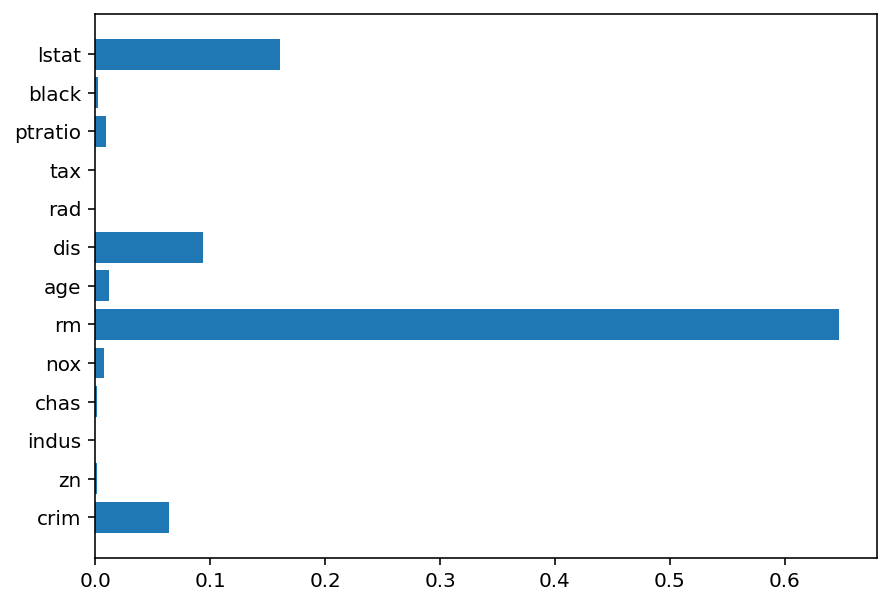

In [43]:
# 변수 중요도
plt.figure(figsize=(7,5))
plt.barh(y=list(x),width=model.best_estimator_.feature_importances_)
plt.show()

# 6. 성능 평가

- 학습을 통해 예상한 성능과 실제 평가에 따른 성능은 차이가 있을 수 있습니다.
- 예선전에서 성적이 좋았다고 본선에서도 성적이 좋다고 보장할 수는 없겠지요?

In [44]:
# 예측하기
y_pred = model.predict(x_test)

In [45]:
# 평가하기
print('MAE:',mean_absolute_error(y_test,y_pred))
print('r2_score:',r2_score(y_test,y_pred))

MAE: 3.289997930052067
r2_score: 0.7155124286118656
